# Data Mining and Web Analytics

This notebook will document all the code, and their accompanying descriptions/explanations for the Data Mining Individual Coursework

## Table of Contents

1. Environment Setup and Data Loading
2. Data Pre-Processing

## 1. Environment Setup and Data Loading

This section mainly imports the required libraries we'll need later on + loading the data into our working environment. Please refer to the comments for specific explanations regarding the code

In [1]:
# load in the libraries

# data manipulation libraries
import pandas as pd
import numpy as np

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# base libraries
import os
import time

# we will be importing more as we go on as it becomes required

In [2]:
# change our working directory (where our files will be)
os.chdir(r'M:\Msc Business Analytics\Semester 2\Data Mining and Web Analytics\Coursework\Dataset')

In [3]:
# load in the file
# we set the first row of the csv as the header and the first column (id) as our index
file = pd.read_csv('CW_training_final.csv', header=0, index_col=0)
guide = pd.read_excel('Metadata.xlsx', header=0)

In [4]:
# inspect the first 5 rows of our loaded in dataframe
file.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
id,,,,,,,,,,,,,,,,,,,,,
1,60.0,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2.0,2008.0,WD,Normal,208500.0
2,20.0,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5.0,2007.0,WD,Normal,181500.0
3,60.0,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9.0,2008.0,WD,Normal,223500.0
4,60.0,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12.0,2008.0,WD,Normal,250000.0
5,50.0,RL,85.0,14115.0,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10.0,2009.0,WD,Normal,143000.0


Great, our data is loaded in now time to do some initial data processing

## 2. Data Pre-Processing

In this section we'll be implementing some initial data pre-processinng steps (before the transformation and all that) such as:
- Selection of our variables (we don't need every single one of the 79 variables)
- Mapping the proper categorical labels to the variables so it's more intuitive
- Convert all variables to their correct type
- Split our dataset into training and test sets before exploration

### 2.1 Variable Selection

We'll select the variables we need here rather than all 79 of them. This step only selects our variables based on intuition. We'll explore the data later on and reduce our data to 10 features which we'll actually be modelling.

The idea behind using intuition at this stage is to not take too close of a look at the whole dataset before splitting to our training and test sets, and inadverdently committing the crime of data snooping (we observe features of our validation or test sets before we train the model)

*We also avoid keeping subjective or ambigous features such as Overall Quality of Overall Condition, mainly because these are of course, subjective, and would only be known after a project has finished, which contradicts with the purpose of this analysis*

In [5]:
file.shape

(1144, 80)

In [6]:
# The below code removes all the columns we think we dont necessarily need

# print shape of our dataset before removing columns
print(file.shape)

# we assign a list with all the columns we require (the ones we're keeping)
features_to_keep = ['MSSubClass', 'MSZoning', 'LotArea', 'Neighborhood', 'BldgType',
                    'HouseStyle', 'Exterior1st', 'Condition1', 'ExterQual', 'BsmtQual',
                    'Heating', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Function', 'Functional',
                    'Fireplaces', 'GarageType', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'PoolArea',
                    'SaleType', 'SaleCondition', 'SalePrice']

# next we run a loop over the accidents dataset to only keep columns in the previous list
for column in file:
    if column not in features_to_keep:
        del file[column]


# print shape of our dataset after removing columns
print(file.shape)

(1144, 80)
(1144, 22)


In [7]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144 entries, 1 to 1144
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1144 non-null   float64
 1   MSZoning       1144 non-null   object 
 2   LotArea        1144 non-null   float64
 3   Neighborhood   1144 non-null   object 
 4   Condition1     1144 non-null   object 
 5   BldgType       1144 non-null   object 
 6   HouseStyle     1144 non-null   object 
 7   Exterior1st    1144 non-null   object 
 8   ExterQual      1144 non-null   object 
 9   BsmtQual       1119 non-null   object 
 10  Heating        1144 non-null   object 
 11  TotRmsAbvGrd   1144 non-null   float64
 12  Functional     1144 non-null   object 
 13  Fireplaces     1144 non-null   float64
 14  GarageType     1091 non-null   object 
 15  GarageCars     1144 non-null   float64
 16  GarageArea     1144 non-null   float64
 17  WoodDeckSF     1144 non-null   float64
 18  PoolArea

We can notice above that despite being a categorical variable, the variable type of MSSubClass is set to Float (numerical), so we'll change the type to the correct one.

In [8]:
# change MSSubClass variable type
file['MSSubClass'] = file['MSSubClass'].astype(object) 

### 2.2 Mapping the Categorical Variables

Right now we can see that our data has numbers or abbreviations that stand for actual labels (for instance the MSubClass). It makes more sense going forward to actually see and know what those values stand for. So this part is all about mapping them to their actual labels

In [9]:
# select the categorical variables we will be mapping
catvar = file.select_dtypes(['object']).columns.tolist()

# get the label data as a grouped object from the data guide
grouped = guide.groupby(guide['column'])

# define a function to create individual dictionaries for each categorical variable and value pair
def getfunc(object, column):
    
    # gets the group corresponding to the categorical column and drops non-required columns
    x = object.get_group(column).drop(columns=['column'])

    # convert the object to a dictionary with only the code/format and label columns remaining
    x = x.set_index('value')['label'].to_dict()

    return x 

# we can use this function for all of our datasets

In [10]:
# run the function over all columns we are keeping
# this will replace the existing values with the intuitive labels 
for column in catvar:
    file[column] = file[column].map(getfunc(grouped, column))

In [11]:
file.head()

,MSSubClass,MSZoning,LotArea,Neighborhood,Condition1,BldgType,HouseStyle,Exterior1st,ExterQual,BsmtQual,...,Functional,Fireplaces,GarageType,GarageCars,GarageArea,WoodDeckSF,PoolArea,SaleType,SaleCondition,SalePrice
id,,,,,,,,,,,,,,,,,,,,,
1,2-STORY 1946 & NEWER,Residential Low Density,8450.0,College Creek,Normal,Single-family Detached,Two story,Vinyl Siding,Good,Good (90-99 inches),...,Typical Functionality,0.0,Attached to home,2.0,548.0,0.0,0,Warranty Deed - Conventional,Normal Sale,208500.0
2,1-STORY 1946 & NEWER ALL STYLES,Residential Low Density,9600.0,Veenker,Adjacent to feeder street,Single-family Detached,One story,Metal Siding,Average/Typical,Good (90-99 inches),...,Typical Functionality,1.0,Attached to home,2.0,460.0,298.0,0,Warranty Deed - Conventional,Normal Sale,181500.0
3,2-STORY 1946 & NEWER,Residential Low Density,11250.0,College Creek,Normal,Single-family Detached,Two story,Vinyl Siding,Good,Good (90-99 inches),...,Typical Functionality,1.0,Attached to home,2.0,608.0,0.0,0,Warranty Deed - Conventional,Normal Sale,223500.0
4,2-STORY 1946 & NEWER,Residential Low Density,14260.0,Northridge,Normal,Single-family Detached,Two story,Vinyl Siding,Good,Good (90-99 inches),...,Typical Functionality,1.0,Attached to home,3.0,836.0,192.0,0,Warranty Deed - Conventional,Normal Sale,250000.0
5,1-1/2 STORY FINISHED ALL AGES,Residential Low Density,14115.0,Mitchell,Normal,Single-family Detached,One and one-half story: 2nd level finished,Vinyl Siding,Average/Typical,Good (90-99 inches),...,Typical Functionality,0.0,Attached to home,2.0,480.0,40.0,0,Warranty Deed - Conventional,Normal Sale,143000.0


As we can see now we have data that makes more sense than the abbreviations used earlier. We will proceed to do some Exploratory Data Analysis on this. But before that, we will split the dataset into training and test sets to ensure we do not do any data-snooping.

### 2.3 Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

# split our data into train and test sets
# the test set will be 20% of our dataset
trainset, testset = train_test_split(file, test_size=0.2, random_state=7)

In [13]:
print(trainset.shape, testset.shape)

(915, 22) (229, 22)


We can see we have 900 records in the training set and 200 records in the testing or validation set. 

## Exploratory Data Analysis

In [14]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 1060 to 176
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     852 non-null    object 
 1   MSZoning       908 non-null    object 
 2   LotArea        915 non-null    float64
 3   Neighborhood   786 non-null    object 
 4   Condition1     915 non-null    object 
 5   BldgType       846 non-null    object 
 6   HouseStyle     915 non-null    object 
 7   Exterior1st    915 non-null    object 
 8   ExterQual      915 non-null    object 
 9   BsmtQual       915 non-null    object 
 10  Heating        915 non-null    object 
 11  TotRmsAbvGrd   915 non-null    float64
 12  Functional     915 non-null    object 
 13  Fireplaces     915 non-null    float64
 14  GarageType     915 non-null    object 
 15  GarageCars     915 non-null    float64
 16  GarageArea     915 non-null    float64
 17  WoodDeckSF     915 non-null    float64
 18  PoolAre

### Uni-Variate - Looking at Sales Price

Text(0.5, 1.0, 'Distribution of Sales Price')

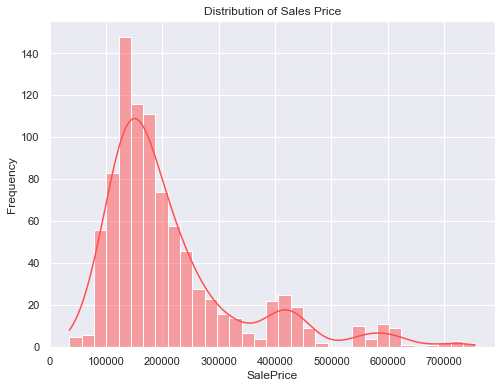

In [15]:
# histogram of the numerical sales price variable
sns.set_theme(style='darkgrid', palette='deep')

sns.set(rc={'figure.figsize':(8,6)})

# plot the histogram
ax = sns.histplot(data=trainset, x='SalePrice', color='#ff5050', kde=True)
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Sales Price')

In [16]:
print(np.mean(trainset['SalePrice']))
print(np.median(trainset['SalePrice']))
print(np.std(trainset['SalePrice']))

215234.1017673224
175000.0
126362.18893415976


Text(0.5, 1.0, 'Average House Price by Functional Types')

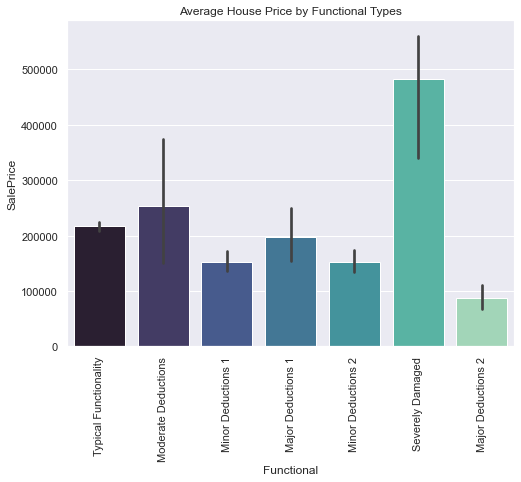

In [17]:
ax = sns.barplot(data=trainset, y='SalePrice', x='Functional', palette='mako')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Average House Price by Functional Types')

Text(0.5, 1.0, 'Total number of houses by Functional Type')

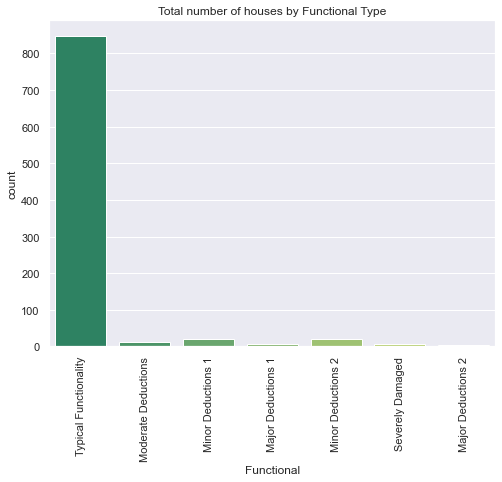

In [18]:
ax = sns.countplot(data=trainset, x='Functional', palette='summer')

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Total number of houses by Functional Type')

Text(0.5, 1.0, 'Sale Price of Property against Lot Area')

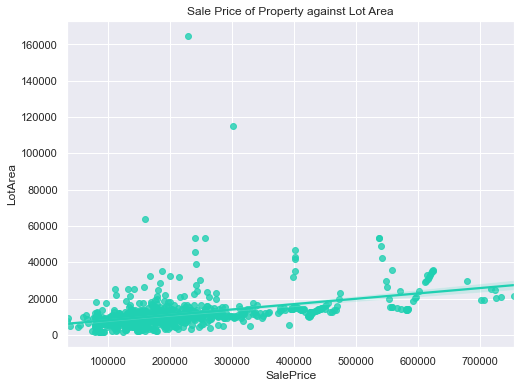

In [19]:
# do a scatter plot to visualize any potential relationship with area and Sale Price
ax = sns.regplot(data=trainset, x='SalePrice', y='LotArea', color='#20d0b2')

ax.set_title('Sale Price of Property against Lot Area')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002962B617130>,
      dtype=object)

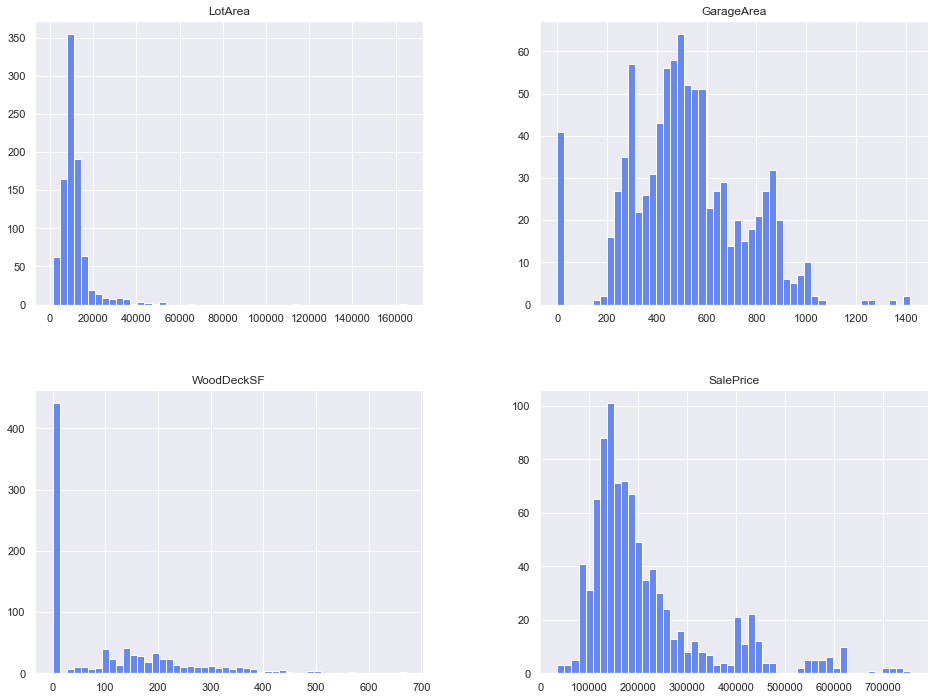

In [20]:
# set seaborn theme
sns.set_theme(style='darkgrid', palette='coolwarm')

# drop the longitude and latitude numerical variables as they represent geographical data
numerical_vis = trainset.drop(columns=['TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea'])

# plot a histogram containing all numerical variables in the dataset.
numerical_vis.hist(bins=50, figsize=(16,12), histtype='bar')


In [21]:
# assign a dataframe with all of our missing values
catvar = trainset[['MSSubClass', 'Neighborhood', 'MSZoning', 'BldgType']]

<ipython-input-22-31ab77cf3967>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catvar[col] = catvar[col].str.replace(" ", "\n")


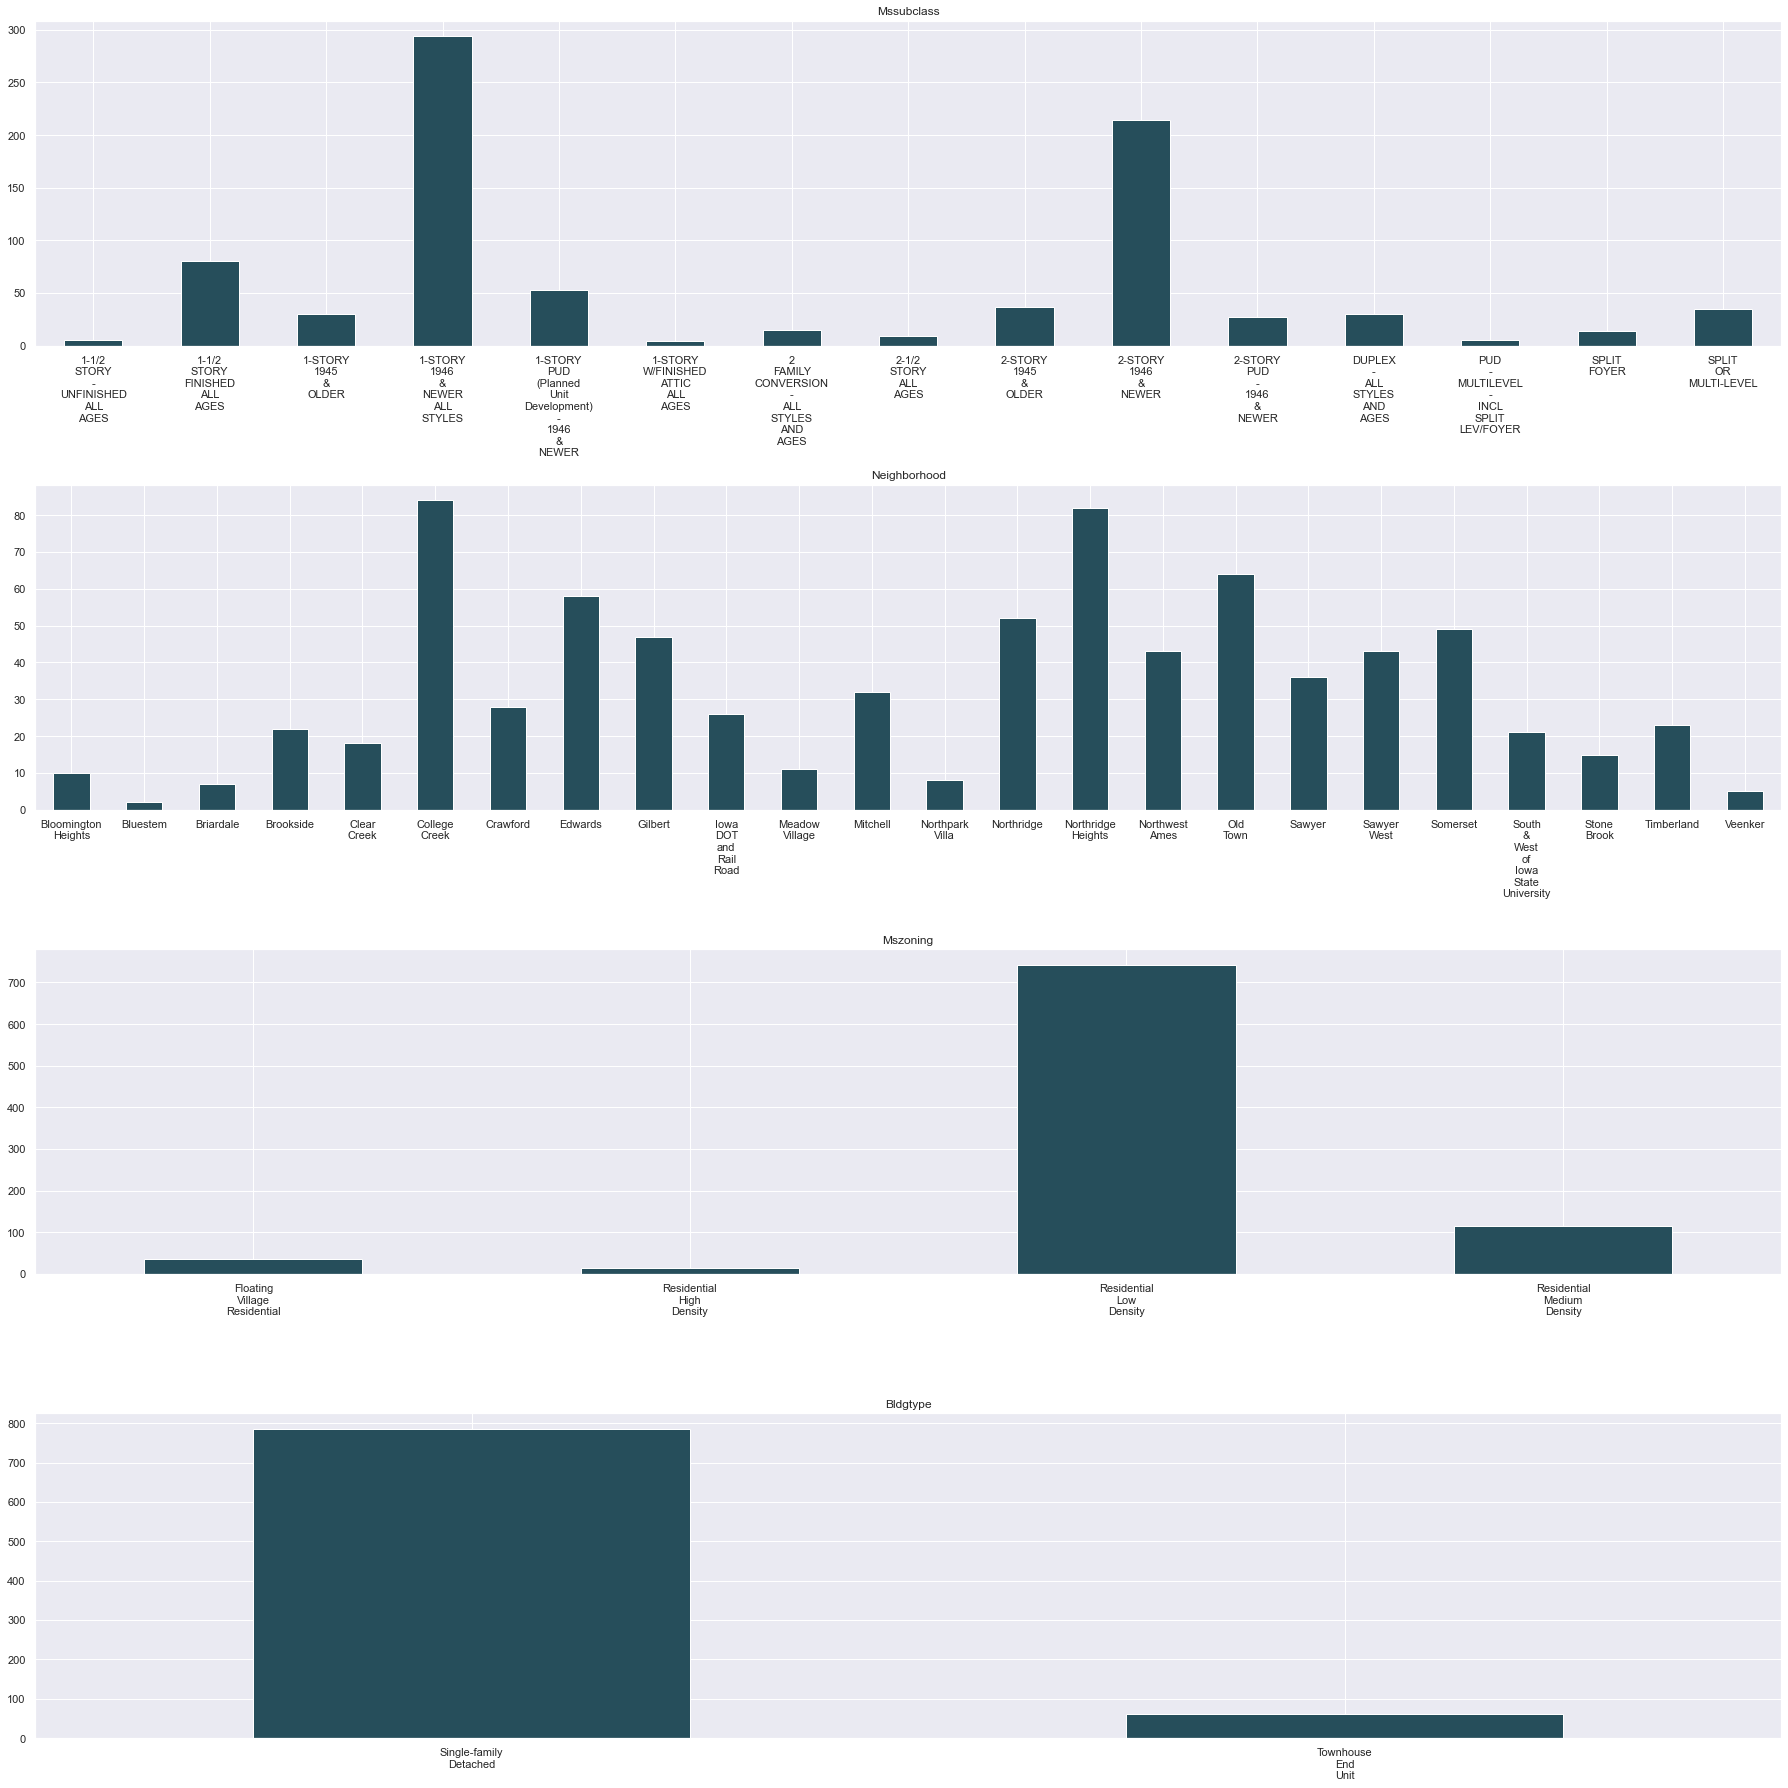

In [22]:
# import the required libraries
from matplotlib import rc
import matplotlib.pyplot as plt


# we call the subplot method to create one plot including many different ones
fig, axes = plt.subplots(ncols=1, nrows=catvar.shape[1], figsize=(25,25))


for col, ax in zip(catvar.columns, np.ravel(axes)):
    catvar[col] = catvar[col].str.replace(" ", "\n")
    catvar[col].value_counts(sort=False).sort_index().plot(
        kind='bar', ax=ax, color='#264e5b', rot=0,
        title=col.replace("_", " ").title(),
    )


plt.tight_layout()
plt.show()
plt.clf()
plt.close()

Miscellaneous Code we'll be using later

## Data Cleaning

We will be cleaning and transforming our dataset to ensure data quality in this section. This includes:
- Handling Missing Values
- Handling Outliers
- Identifying and Treating any Anomalous Data

### Missing Values

In [23]:
# lets see how much missing data we have
trainset.isnull().sum()

MSSubClass        63
MSZoning           7
LotArea            0
Neighborhood     129
Condition1         0
BldgType          69
HouseStyle         0
Exterior1st        0
ExterQual          0
BsmtQual           0
Heating            0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
GarageType         0
GarageCars         0
GarageArea         0
WoodDeckSF         0
PoolArea           0
SaleType           0
SaleCondition      0
SalePrice          0
dtype: int64

Seems we have missing data in MSSubClass, Neighborhood, MSZoning, and BuildingType in the Trainset as well as the TestSet. As we have already described in the main report, we will be removing missing values for MSSubClass and Neighborhood, whilst imputing missing values with Mode for MSZoning, and BldgType.

In [24]:
# all the code below does is
    # defines a function to remove any missing values from the specified columns

# define function to drop the na for category and remove accident index and age band of driver
def dropna(data, cols):

    # drop all null values in the specified subset of columns
    data = data.dropna(subset=cols)

    # return the updated data
    return data

# define the subset of columns for which our function will remove the null values
subset = ['MSSubClass', 'Neighborhood']


# implement the dropna function for our train and test sets
trainset = dropna(trainset, subset)
testset = dropna(testset, subset)


# lets inspect the dimensions of the dataset to see how big it is
print(trainset.shape, testset.shape)

(725, 22) (183, 22)


Now that we've removed the missing values, let's get to the imputing bit

In [25]:
trainset.isnull().sum()

MSSubClass        0
MSZoning          7
LotArea           0
Neighborhood      0
Condition1        0
BldgType         58
HouseStyle        0
Exterior1st       0
ExterQual         0
BsmtQual          0
Heating           0
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
GarageType        0
GarageCars        0
GarageArea        0
WoodDeckSF        0
PoolArea          0
SaleType          0
SaleCondition     0
SalePrice         0
dtype: int64

We can see above that no missing values are there for MSSubClass and Neighborhoods anymore since the values were removed

In [27]:
# import the SimpleImputer class and instantiate the object
from sklearn.impute import SimpleImputer

# instantiate imputer object with mode (most frequent) set as the strategy
imputer = SimpleImputer(strategy ='most_frequent')


# define a function that imputes missing values on a given train,test dataset pair.
def imputefunc(trainset, testset):

    # fit the impute on our training set and subsequently transform both sets
    trainset = pd.DataFrame(imputer.fit_transform(trainset),columns = trainset.columns)
    testset = pd.DataFrame(imputer.transform(testset), columns = testset.columns)
    
    # reset the index of both our sets as concatenation requires consistent indexes
    trainset.reset_index(level=0, inplace=True)
    trainset.reset_index(level=0, inplace=True)  
    
    return trainset, testset


trainset, testset = imputefunc(trainset, testset)

In [28]:
trainset.isnull().sum()

level_0          0
index            0
MSSubClass       0
MSZoning         0
LotArea          0
Neighborhood     0
Condition1       0
BldgType         0
HouseStyle       0
Exterior1st      0
ExterQual        0
BsmtQual         0
Heating          0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
PoolArea         0
SaleType         0
SaleCondition    0
SalePrice        0
dtype: int64

We now have a dataset with no missing values whatsoever, we'll now proceed with handling anomalous data

### Anomalies

### Initial Modelling and Feature Selection

In [ ]:
# import random forest classifier
from sklearn.ensemble import RandomForestRegressor

# instantiate a Random Forest with 100 trees and max depth of 7
rf = RandomForestRegressor(n_estimators=100, random_state=7, max_depth=7)


rf.fit)



The grid search code

In [ ]:
# define the grid search parameters
param_grid = [
    {   
        'alpha': [0.001 ,0.01, 0.1, 1],
        'activation': ['logistic', 'identity'],
    },
]

mlp_grid_search = GridSearchCV(Mlpclassifier, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

# fit the neural network to our data
mlp_grid_search.fit(x_train, y_train)